In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

Sun Sep 11 17:13:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Used for specifying path in Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


# Load necessary libarary

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import math
import time 

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

#Check GPU acceleration

In [5]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Creat computational domain

In [6]:
n = 5          # aspect ratio of z to x and y ==> also means the number of cell at the final grid level 
               #                              ==> should be fine if below 20
alpha = 1      # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128       # Grid point in x
ny = 128       # Grid point in y
nz = nx*n      # Grid point in z

#Design the weights in filter 

1.   The idea is to generate six filters representing each direction of discretisation, **west**, **east**, **north**, **south**, **top** and **bottom**.
2.   **m1** -> **i-1**;**j-1**;**k-1**
3.   **p1** -> **i+1**;**j+1**;**k+1**



In [7]:
# the weights matrix
w1 = np.zeros([1,2,2,2,1])
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])
w5 = np.zeros([1,3,3,3,1])
w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w1[0,:,:,:,0] = 0.125

pxm1 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]
pxm2 = [[0.0, 0.0,  0.0],
       [1.0, -1.0,  0.0],
       [0.0, 0.0,  0.0]]
pxm3 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]

pxp1 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]
pxp2 = [[0.0, 0.0,  0.0],
       [0.0, -1.0, 1.0],
       [0.0, 0.0,  0.0]]
pxp3 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]

pym1 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]
pym2 = [[0.0, 1.0,  0.0],
       [0.0, -1.0,  0.0],
       [0.0, 0.0,  0.0]]
pym3 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]

pyp1 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]
pyp2 = [[0.0, 0.0,  0.0],
       [0.0, -1.0, 0.0],
       [0.0, 1.0,  0.0]]
pyp3 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]

pzm1 = [[0.0, 0.0,  0.0],
       [0.0, 1.0,  0.0],
       [0.0, 0.0,  0.0]]
pzm2 = [[0.0, 0.0,  0.0],
       [0.0, -1.0,  0.0],
       [0.0, 0.0,  0.0]]
pzm3 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]

pzp1 = [[0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0],
       [0.0, 0.0,  0.0]]
pzp2 = [[0.0, 0.0,  0.0],
       [0.0, -1.0, 0.0],
       [0.0, 0.0,  0.0]]
pzp3 = [[0.0, 0.0,  0.0],
       [0.0, 1.0,  0.0],
       [0.0, 0.0,  0.0]]

w2[0,0,:,:,0] = -np.array(pxm1) 
w2[0,1,:,:,0] = -np.array(pxm2) 
w2[0,2,:,:,0] = -np.array(pxm3) 

w3[0,0,:,:,0] = -np.array(pxp1) 
w3[0,1,:,:,0] = -np.array(pxp2) 
w3[0,2,:,:,0] = -np.array(pxp3) 

w4[0,0,:,:,0] = -np.array(pym1) 
w4[0,1,:,:,0] = -np.array(pym2) 
w4[0,2,:,:,0] = -np.array(pym3) 

w5[0,0,:,:,0] = -np.array(pyp1) 
w5[0,1,:,:,0] = -np.array(pyp2) 
w5[0,2,:,:,0] = -np.array(pyp3) 

w6[0,0,:,:,0] = -np.array(pzm1) 
w6[0,1,:,:,0] = -np.array(pzm2) 
w6[0,2,:,:,0] = -np.array(pzm3) 

w7[0,0,:,:,0] = -np.array(pzp1) 
w7[0,1,:,:,0] = -np.array(pzp2) 
w7[0,2,:,:,0] = -np.array(pzp3) 

# Weights of layers

In [8]:
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

# Jacobi A matrix

In [9]:
for i in range(8):
  locals()['CNN3D_A_xm1_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(7-i)), int(ny*0.5**(7-i)), int(nx*0.5**(7-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer)
  ])

In [10]:
for i in range(8):
  locals()['CNN3D_A_xp1_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(7-i)), int(ny*0.5**(7-i)), int(nx*0.5**(7-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer)
  ])

In [11]:
for i in range(8):
  locals()['CNN3D_A_ym1_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(7-i)), int(ny*0.5**(7-i)), int(nx*0.5**(7-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer)
  ])

In [12]:
for i in range(8):
  locals()['CNN3D_A_yp1_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(7-i)), int(ny*0.5**(7-i)), int(nx*0.5**(7-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer)
  ])

In [13]:
for i in range(8):
  locals()['CNN3D_A_zm1_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(7-i)), int(ny*0.5**(7-i)), int(nx*0.5**(7-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer)
  ])

In [14]:
for i in range(8):
  locals()['CNN3D_A_zp1_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(7-i)), int(ny*0.5**(7-i)), int(nx*0.5**(7-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer)
  ])

# Restriction & prolongation matrix

In [15]:
for i in range(7):
  locals()['CNN3D_res_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(6-i)), int(ny*0.5**(6-i)), int(nx*0.5**(6-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
  ])    

In [16]:
for i in range(7):
  locals()['CNN3D_prol_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*n*2**i, 1*2**i, 1*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
  ])

In [17]:
CNN3D_res_128.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_54 (Conv3D)          (None, 320, 64, 64, 1)    9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [18]:
CNN3D_prol_64.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling3d_6 (UpSampling  (None, 640, 128, 128, 1)  0        
 3D)                                                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


# Load data

In [19]:
T = np.zeros([nz,ny,nx])
for i in range(40):
    for j in range(40):
        for k in range(160):
            T[k+240][j+43][i+43] = 1 

In [20]:
input_shape = (1,nz,ny,nx,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)
values = tf.Variable(values)[0,:,:,:,0].assign(tf.Variable(values)[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))

values.shape:  (1, 640, 128, 128, 1)


# Functions for Boundary conditions

In [21]:
def boundary_condition_top(values):
    'Specify Neumann boundary condition at the top of domain'
    temp = tf.Variable(values)
    temp[0,0,:,:,0].assign(tf.Variable(values)[0,1,:,:,0]) 
    return temp


# Initial condition

Text(0.5, 1.0, 'central xy plane')

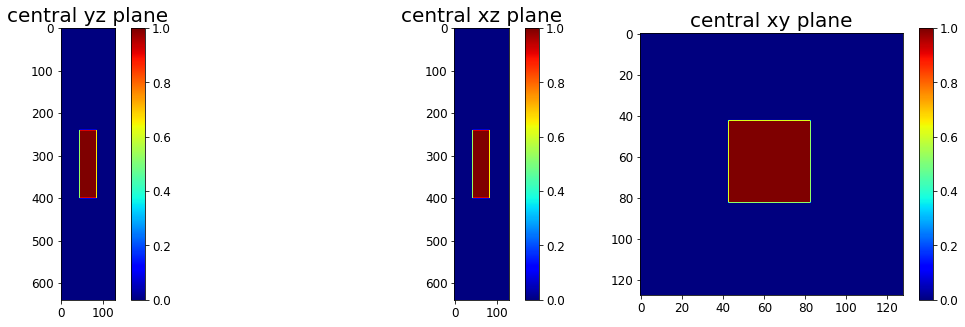

In [22]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,63,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,63,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,320,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

# Mesh generation 

---
This section is used to generate non-uniform mesh. 

*   The mesh matrices **mesh_x**, **mesh_y** and **mesh_z** represent the grid size in **x**, **y** and **z** direction. 
*   There are two ways to generate required mesh matrix: **1)** using the code below to manually create mesh size in 3D matrix; **2)** read the mesh file (i.e., msh file produced by GMSH) into mesh matrix and calculate the mesh size by shifting matrix.
*   The dimensional of each mesh matrix is same with the field matrix **(1,nz,ny,nx,1)**. The idea is using these mesh matrices to formulate activation function with. 
*   Hence, to build up the mesh matrix, it actually just need to determine the mesh size in one direction, i.e., creating **mesh_x** just need to distribute **dx** in **x** direction and repeat it to make up three-dimensional matrix. 
*  This idea might not be a clever one as 3D matrix would cause more computational cost but it can work and won't make a big difference on computing efficiency if using GPU. 











Text(0.5, 1.0, 'dz in yz plane')

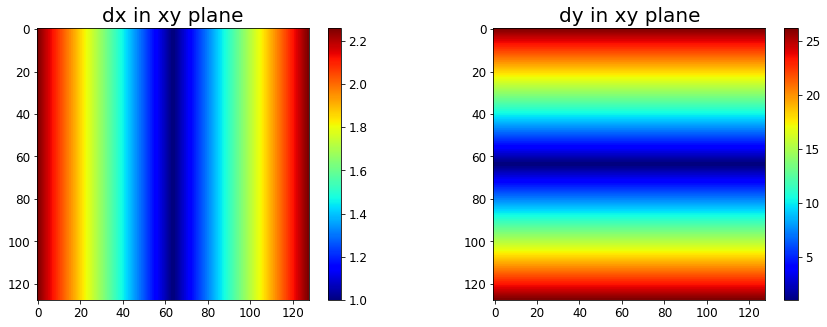

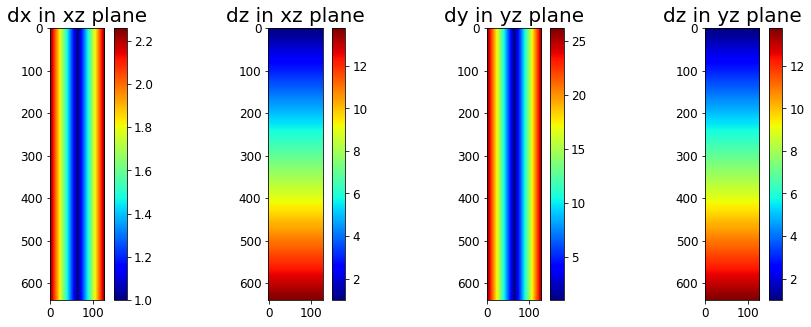

In [23]:
# ------------------ Do not need this part if loading a msh file ---------------
mesh_x = np.zeros(input_shape)
mesh_y = np.zeros(input_shape)
mesh_z = np.zeros(input_shape)
for i in range(64):
  mesh_x[0,:,:,64+i,0] = 1.0 + 0.02*i
  mesh_x[0,:,:,63-i,0] = 1.0 + 0.02*i     
  mesh_y[0,:,64+i,:,0] = 1.0 + 0.4*i
  mesh_y[0,:,63-i,:,0] = 1.0 + 0.4*i   
for i in range(128*n):
  mesh_z[0,i,:,:,0] = 1.0 + 0.02*i
# ------------------------------------------------------------------------------
# ==>> Just need to keep the same name mesh_x, mesh_y and mesh_z 


# ------------------------------- Visualise mesh -------------------------------
fig, ax = plt.subplots(1,2, figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow(mesh_x[0,5,:,:,0], cmap='jet')
plt.colorbar()
plt.title('dx in xy plane',Fontsize=20)
plt.subplot(1,2,2)
plt.imshow(mesh_y[0,5,:,:,0], cmap='jet')
plt.colorbar()
plt.title('dy in xy plane',Fontsize=20)

fig, ax = plt.subplots(1,4, figsize=[15,5])
plt.subplot(1,4,1)
plt.imshow(mesh_x[0,:,5,:,0], cmap='jet')
plt.colorbar()
plt.title('dx in xz plane',Fontsize=20)
plt.subplot(1,4,2)
plt.imshow(mesh_z[0,:,5,:,0], cmap='jet')
plt.colorbar()
plt.title('dz in xz plane',Fontsize=20)
plt.subplot(1,4,3)
plt.imshow(mesh_y[0,:,:,5,0], cmap='jet')
plt.colorbar()
plt.title('dy in yz plane',Fontsize=20)
plt.subplot(1,4,4)
plt.imshow(mesh_z[0,:,:,5,0], cmap='jet')
plt.colorbar()
plt.title('dz in yz plane',Fontsize=20)

# Mesh shifting
This section aims to shift the mesh matrices that are created from the last section. Hence, there are totally 6 mesh matrices:
*   mesh_x -> grid size in x direction 
*   mesh_x_p1 -> shifted grid size in x direction 
*   mesh_y -> grid size in y direction 
*   mesh_y_p1 -> shifted grid size in y direction 
*   mesh_z -> grid size in z direction 
*   mesh_z_p1 -> shifted grid size in z direction

i.e., the orignial mesh_x is \
**5.0** 2.0 1.0 0.5 0.5 1.0 2.0 **5.0** \
the shifted mesh_x_p1 is \
**5.0** 1.0 0.5 0.5 1.0 2.0 5.0 **5.0** \
where bond one represent boundary. 



Text(0.5, 1.0, 'dz in yz plane')

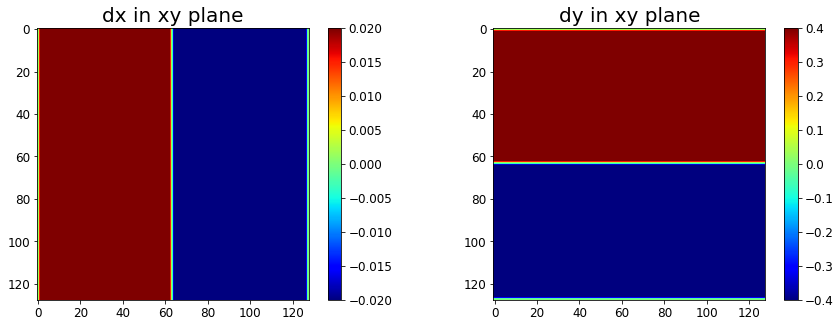

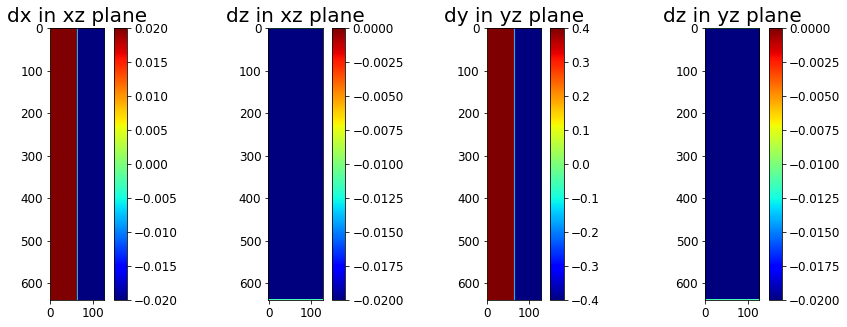

In [24]:
mesh_x_p1 = mesh_x.copy()
mesh_y_p1 = mesh_y.copy()
mesh_z_p1 = mesh_z.copy()

for i in range(126):
  mesh_x_p1[0,:,:,(i+1),0] = mesh_x[0,:,:,(i+2),0]
  mesh_y_p1[0,:,(i+1),:,0] = mesh_y[0,:,(i+2),:,0]
for i in range(int(128*n-2)):
  mesh_z_p1[0,(i+1),:,:,0] = mesh_z[0,(i+2),:,:,0]
  
# ------------------------------- Visualise mesh -------------------------------
fig, ax = plt.subplots(1,2, figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow((mesh_x-mesh_x_p1)[0,5,:,:,0], cmap='jet')
plt.colorbar()
plt.title('dx in xy plane',Fontsize=20)
plt.subplot(1,2,2)
plt.imshow((mesh_y-mesh_y_p1)[0,5,:,:,0], cmap='jet')
plt.colorbar()
plt.title('dy in xy plane',Fontsize=20)

fig, ax = plt.subplots(1,4, figsize=[15,5])
plt.subplot(1,4,1)
plt.imshow((mesh_x-mesh_x_p1)[0,:,5,:,0], cmap='jet')
plt.colorbar()
plt.title('dx in xz plane',Fontsize=20)
plt.subplot(1,4,2)
plt.imshow((mesh_z-mesh_z_p1)[0,:,5,:,0], cmap='jet')
plt.colorbar()
plt.title('dz in xz plane',Fontsize=20)
plt.subplot(1,4,3)
plt.imshow((mesh_y-mesh_y_p1)[0,:,:,5,0], cmap='jet')
plt.colorbar()
plt.title('dy in yz plane',Fontsize=20)
plt.subplot(1,4,4)
plt.imshow((mesh_z-mesh_z_p1)[0,:,:,5,0], cmap='jet')
plt.colorbar()
plt.title('dz in yz plane',Fontsize=20)

# Involving conductivity and need modify based on the cases
*   Dx --> conductivity in x direction 
*   Dy --> conductivity in y direction 
*   Dz --> conductivity in z direction 

Producing 6 components in A matrix:\

*   A_MAT_xml --> (i-1,j,k)
*   A_MAT_xpl --> (i+1,j,k)
*   A_MAT_yml --> (i,j-1,k)
*   A_MAT_ypl --> (i,j+1,k)
*   A_MAT_zml --> (i,j,k-1)
*   A_MAT_zpl --> (i,j,k+1)
*   A_MAT_TOT --> (i,j,k) \

Number 1, 2, 4, 8, 16, 32, 64, 128 represesnt the A matrix at nth grid level.

In [25]:
Dx = np.ones(input_shape)*100
Dy = np.ones(input_shape)*100
Dz = np.ones(input_shape)*100

A_MAT_xm1_128 = Dx/(mesh_x**2)
A_MAT_ym1_128 = Dy/(mesh_y**2)
A_MAT_zm1_128 = Dz/(mesh_z**2)

A_MAT_xp1_128 = Dx/(mesh_x_p1**2)
A_MAT_yp1_128 = Dy/(mesh_y_p1**2)
A_MAT_zp1_128 = Dz/(mesh_z_p1**2)

A_MAT_TOT_128 = (A_MAT_xm1_128 + A_MAT_ym1_128 + \
A_MAT_zm1_128 + A_MAT_xp1_128 + A_MAT_yp1_128 + A_MAT_zp1_128)

for i in range(7):
   CNN = locals()['CNN3D_res_'+str(2**(7-i))]

   temp_xm1 = locals()['A_MAT_xm1_'+str(2**(7-i))]
   temp_ym1 = locals()['A_MAT_ym1_'+str(2**(7-i))]
   temp_zm1 = locals()['A_MAT_zm1_'+str(2**(7-i))]
   temp_xp1 = locals()['A_MAT_xp1_'+str(2**(7-i))]
   temp_yp1 = locals()['A_MAT_yp1_'+str(2**(7-i))]
   temp_zp1 = locals()['A_MAT_zp1_'+str(2**(7-i))]
   temp_TOT = locals()['A_MAT_TOT_'+str(2**(7-i))] 

   locals()['A_MAT_xm1_'+str(2**(6-i))] = CNN(temp_xm1)
   locals()['A_MAT_ym1_'+str(2**(6-i))] = CNN(temp_ym1)   
   locals()['A_MAT_zm1_'+str(2**(6-i))] = CNN(temp_zm1)
   locals()['A_MAT_xp1_'+str(2**(6-i))] = CNN(temp_xp1)
   locals()['A_MAT_yp1_'+str(2**(6-i))] = CNN(temp_yp1)   
   locals()['A_MAT_zp1_'+str(2**(6-i))] = CNN(temp_zp1)
   locals()['A_MAT_TOT_'+str(2**(6-i))] = CNN(temp_TOT)

#Combine six directions into one function

In [26]:
def A_operator_128(values):
  temp = CNN3D_A_xm1_128(values)*A_MAT_xm1_128 + CNN3D_A_xp1_128(values)*A_MAT_xp1_128 + \
  CNN3D_A_ym1_128(values)*A_MAT_ym1_128 + CNN3D_A_yp1_128(values)*A_MAT_yp1_128 + \
  CNN3D_A_zm1_128(values)*A_MAT_zm1_128 + CNN3D_A_zp1_128(values)*A_MAT_zp1_128
  return temp
def A_operator_64(values):
  temp = CNN3D_A_xm1_64(values)*A_MAT_xm1_64 + CNN3D_A_xp1_64(values)*A_MAT_xp1_64 + \
  CNN3D_A_ym1_64(values)*A_MAT_ym1_64 + CNN3D_A_yp1_64(values)*A_MAT_yp1_64 + \
  CNN3D_A_zm1_64(values)*A_MAT_zm1_64 + CNN3D_A_zp1_64(values)*A_MAT_zp1_64
  return temp
def A_operator_32(values):
  temp = CNN3D_A_xm1_32(values)*A_MAT_xm1_32 + CNN3D_A_xp1_32(values)*A_MAT_xp1_32 + \
  CNN3D_A_ym1_32(values)*A_MAT_ym1_32 + CNN3D_A_yp1_32(values)*A_MAT_yp1_32 + \
  CNN3D_A_zm1_32(values)*A_MAT_zm1_32 + CNN3D_A_zp1_32(values)*A_MAT_zp1_32
  return temp
def A_operator_16(values):
  temp = CNN3D_A_xm1_16(values)*A_MAT_xm1_16 + CNN3D_A_xp1_16(values)*A_MAT_xp1_16 + \
  CNN3D_A_ym1_16(values)*A_MAT_ym1_16 + CNN3D_A_yp1_16(values)*A_MAT_yp1_16 + \
  CNN3D_A_zm1_16(values)*A_MAT_zm1_16 + CNN3D_A_zp1_16(values)*A_MAT_zp1_16
  return temp
def A_operator_8(values):
  temp = CNN3D_A_xm1_8(values)*A_MAT_xm1_8 + CNN3D_A_xp1_8(values)*A_MAT_xp1_8 + \
  CNN3D_A_ym1_8(values)*A_MAT_ym1_8 + CNN3D_A_yp1_8(values)*A_MAT_yp1_8 + \
  CNN3D_A_zm1_8(values)*A_MAT_zm1_8 + CNN3D_A_zp1_8(values)*A_MAT_zp1_8
  return temp
def A_operator_4(values):
  temp = CNN3D_A_xm1_4(values)*A_MAT_xm1_4 + CNN3D_A_xp1_4(values)*A_MAT_xp1_4 + \
  CNN3D_A_ym1_4(values)*A_MAT_ym1_4 + CNN3D_A_yp1_4(values)*A_MAT_yp1_4 + \
  CNN3D_A_zm1_4(values)*A_MAT_zm1_4 + CNN3D_A_zp1_4(values)*A_MAT_zp1_4
  return temp
def A_operator_2(values):
  temp = CNN3D_A_xm1_2(values)*A_MAT_xm1_2 + CNN3D_A_xp1_2(values)*A_MAT_xp1_2 + \
  CNN3D_A_ym1_2(values)*A_MAT_ym1_2 + CNN3D_A_yp1_2(values)*A_MAT_yp1_2 + \
  CNN3D_A_zm1_2(values)*A_MAT_zm1_2 + CNN3D_A_zp1_2(values)*A_MAT_zp1_2
  return temp
def A_operator_1(values):
  temp = CNN3D_A_xm1_1(values)*A_MAT_xm1_1 + CNN3D_A_xp1_1(values)*A_MAT_xp1_1 + \
  CNN3D_A_ym1_1(values)*A_MAT_ym1_1 + CNN3D_A_yp1_1(values)*A_MAT_yp1_1 + \
  CNN3D_A_zm1_1(values)*A_MAT_zm1_1 + CNN3D_A_zp1_1(values)*A_MAT_zp1_1
  return temp

# Multigrid network with skipping layer

In [27]:
start = time.time()
b = values           # only for one time step
multi_itr = 1000     # multigrid iteration
j_itr = 1            # jacobi iteration 
for multi_grid in range(multi_itr):    
    w_1 = np.zeros([1,1*n,1,1,1])
# --------- Calculate Residual based on initial guess --------  
    r = A_operator_128(values) - b 
# ------------------------------------------------------------  

# --------- Interpolate Residual from finer to coaser mesh --------  
    r_64 = CNN3D_res_128(r) 
    r_32 = CNN3D_res_64(r_64) 
    r_16 = CNN3D_res_32(r_32) 
    r_8 = CNN3D_res_16(r_16) 
    r_4 = CNN3D_res_8(r_8) 
    r_2 = CNN3D_res_4(r_4) 
    r_1 = CNN3D_res_2(r_2)    
# -----------------------------------------------------------------      

# --------- Interpolate Residual from coaser to finer mesh --------  
    for Jacobi in range(j_itr):
        w_1 = w_1 - A_operator_1(w_1)/A_MAT_TOT_1 + r_1/A_MAT_TOT_1
    w_2 = CNN3D_prol_1(w_1)                   
    for Jacobi in range(j_itr):
        w_2 = w_2 - A_operator_2(w_2)/A_MAT_TOT_2 + r_2/A_MAT_TOT_2
    w_4 = CNN3D_prol_2(w_2) 
    for Jacobi in range(j_itr):
        w_4 = w_4 - A_operator_4(w_4)/A_MAT_TOT_4 + r_4/A_MAT_TOT_4
    w_8 = CNN3D_prol_4(w_4) 
    for Jacobi in range(j_itr):
        w_8 = w_8 - A_operator_8(w_8)/A_MAT_TOT_8 + r_8/A_MAT_TOT_8
    w_16 = CNN3D_prol_8(w_8) 
    for Jacobi in range(j_itr):
        w_16 = w_16 - A_operator_16(w_16)/A_MAT_TOT_16 + r_16/A_MAT_TOT_16
    w_32 = CNN3D_prol_16(w_16) 
    for Jacobi in range(j_itr):
        w_32 = w_32 - A_operator_32(w_32)/A_MAT_TOT_32 + r_32/A_MAT_TOT_32
    w_64 = CNN3D_prol_32(w_32)
    for Jacobi in range(j_itr):
        w_64 = w_64 - A_operator_64(w_64)/A_MAT_TOT_64 + r_64/A_MAT_TOT_64
    w_128 = CNN3D_prol_64(w_64)
    w_128 = w_128 - A_operator_128(w_128)/A_MAT_TOT_128 + r/A_MAT_TOT_128
# ----------------------------------------------------------------- 

# --------- Correct initial guess --------  
    values = values - w_128 
    values = values - A_operator_128(values)/A_MAT_TOT_128 + b/A_MAT_TOT_128
    values = boundary_condition_top(values)
# ----------------------------------------  
    print('Iteration:', multi_grid)
end = time.time()
print('Computational time(s):',(end-start))
print('Multigrid iterations:', multi_itr)
print('Jacobi iterations:', j_itr)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

### Residual on the 1st grid level

Text(0.5, 1.0, 'central xy plane')

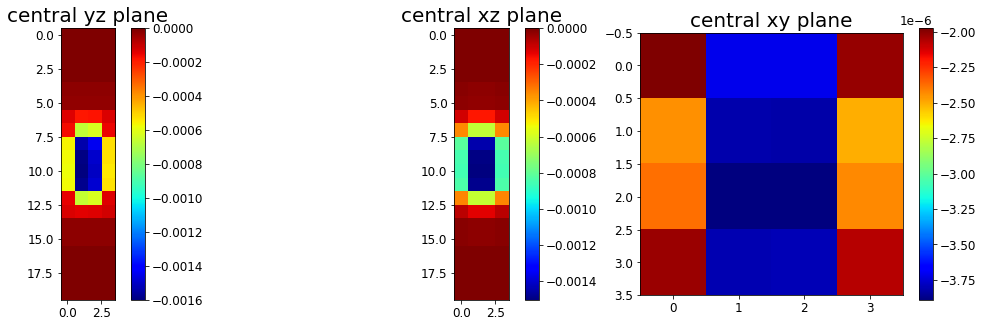

In [28]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_4[0,:,:,2,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_4[0,:,2,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_4[0,2,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on the 2nd grid level

Text(0.5, 1.0, 'central xy plane')

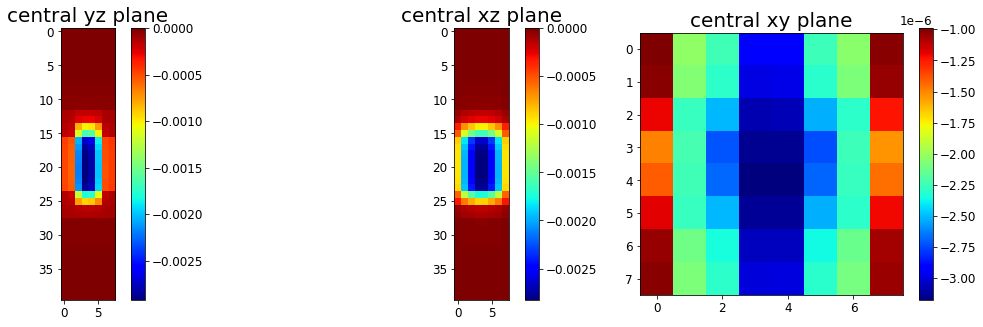

In [29]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_8[0,:,:,4,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_8[0,:,4,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_8[0,4,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on the 3rd grid level

Text(0.5, 1.0, 'central xy plane')

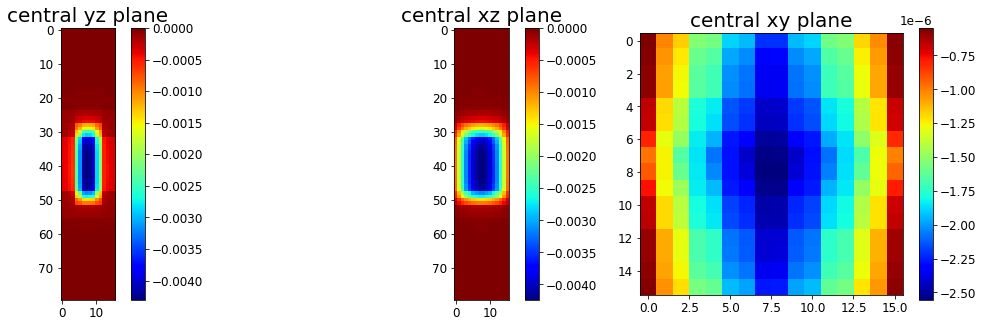

In [30]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_16[0,:,:,8,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_16[0,:,8,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_16[0,8,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on the 4th grid level

Text(0.5, 1.0, 'central xy plane')

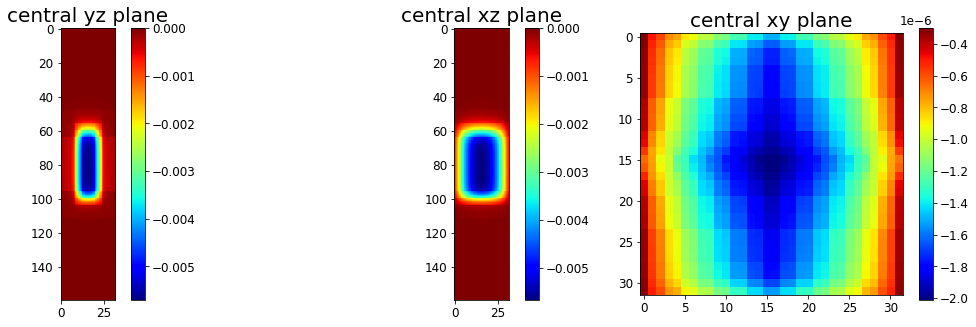

In [31]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_32[0,:,:,16,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_32[0,:,16,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_32[0,16,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on the 5th grid level

Text(0.5, 1.0, 'central xy plane')

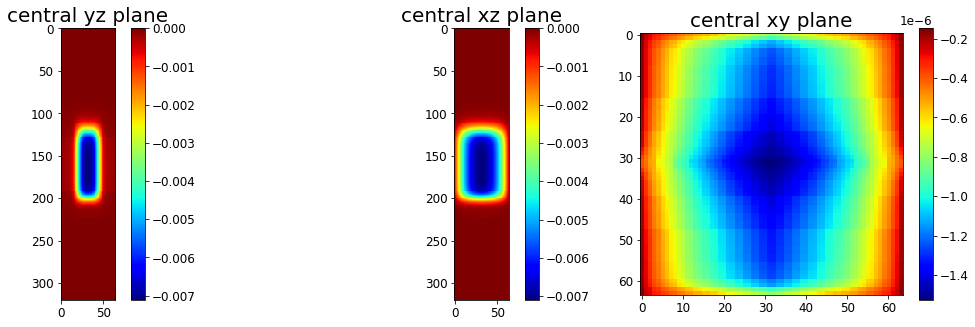

In [32]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_64[0,:,:,32,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_64[0,:,32,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_64[0,32,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Residual on the 6th grid level

Text(0.5, 1.0, 'central xy plane')

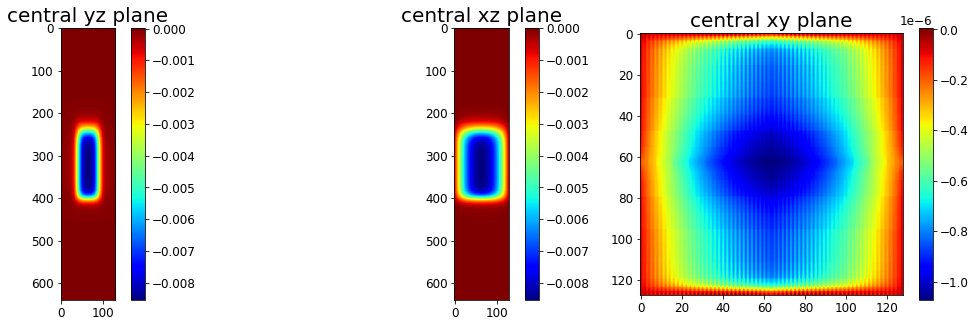

In [33]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(w_128[0,:,:,64,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_128[0,:,64,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_128[0,64,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)

### Steady state results

Text(0.5, 1.0, 'central xy plane')

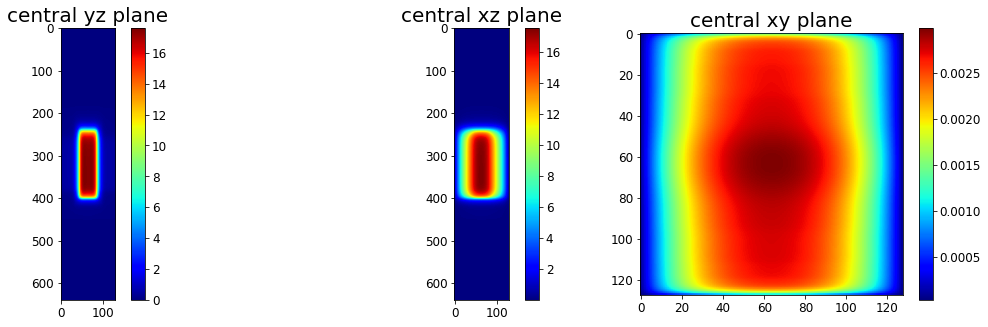

In [34]:
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,64,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',Fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,64,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',Fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,64,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',Fontsize=20)